This is the ipynb notebook for CSC420 Final Project by Henry Heng Yi Lin.

In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Pose estimation using Movenet Tutorial by Tensorflow

https://www.tensorflow.org/lite/tutorials/pose_classification#code_to_run_pose_estimation_using_movenet

For this project, we will be using Tensorflow's pretrained movenet_thunder_f16 pose detection model.

We will later combine this model with our custom trained CNN's for human and cloth segmentation to create the final clothing segmentation model

Code taken from tensorflow's movenet tutorial for pose estimation

Reference: https://www.tensorflow.org/hub/tutorials/movenet

Below is code from the tutorial mentioned above. This code will be used to runthe pretrained Movenet_thunder model for pose estimation which will later be used for pixelwise segmentation

In [107]:
interpreter = tf.lite.Interpreter(model_path="movenet_thunder_f16.tflite")
interpreter.allocate_tensors()
def movenet(input_image):
    """Runs detection on an input image.

    Args:
        input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
        A [1, 1, 17, 3] float numpy array representing the predicted keypoint
        coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores


Helper functions for pose estimation

In [110]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

C:\Users\henry\AppData\Local\Temp\ipykernel_9568\96334677.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


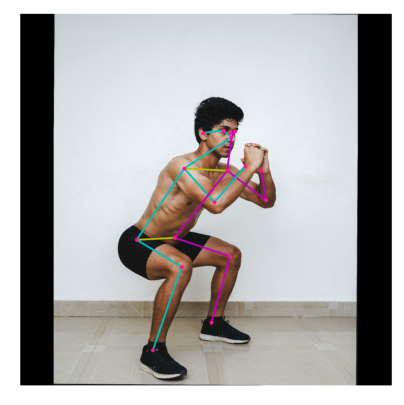

In [113]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
example = './pexels-photo-4384679.jpeg'
example = tf.io.read_file(example)
example = tf.image.decode_jpeg(example)

input_image = tf.expand_dims(example, axis=0)
input_image = tf.image.resize_with_pad(input_image, 128, 128)

# Run model inference.
keypoints_with_scores = movenet(input_image)
# Visualize the predictions with image.
display_image = tf.expand_dims(example, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

# Pixel Wise segmentation using modified Unet model architecture

https://www.tensorflow.org/tutorials/images/segmentation

Import Data if using Google Colab. The rest of this ipynb is coded for local runs.

In [ ]:

# Import libraries
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')

# Path to your files in Google Drive
file_path = "/content/gdrive/My Drive/CSC420Dir"

# List files in the directory
images_list = tf.io.gfile.listdir("/content/gdrive/My Drive/CSC420Dir/project3/images")
labels_list = tf.io.gfile.listdir("/content/gdrive/My Drive/CSC420Dir/project3/labels")
# # List files in the directory

# Assuming you have image files and corresponding mask files, you can use `tf.data.Dataset.from_tensor_slices`
# to create a dataset
image_paths = tf.data.Dataset.from_tensor_slices([f for f in images_list if f.endswith('.jpg')])
mask_paths = tf.data.Dataset.from_tensor_slices([f for f in labels_list if f.endswith('.png')])



Model Training for Human Segmentation

Some helper functions to visualise outputs

In [116]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  pred_mask = tf.image.per_image_standardization(
        pred_mask
  )
  return pred_mask[0]



Below is the code to train a simple CNN network to perform pixel wise segmentation using Tensorflow. We will be saving the masked output from the model to be later piped into the clothing segmentation model to save compute time.

In [ ]:
def load_and_preprocess_image_binary(image_path, mask_path):
    # Load the image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask)

    # Preprocess the image and mask
    image = tf.image.resize(image, (128, 128))
    mask = tf.image.resize(mask, (128, 128))

    image = image / 255
    mask = (mask > 0) 
    
    return image, mask

# Instead of using the base dataset, we modify the images to have its canny edges and pose estimations overlayed. The code to do this can be found below
train_data = tf.data.Dataset.list_files("./poses_and_edges/*.jpg", shuffle=False)
label_data = tf.data.Dataset.list_files("./labels/*person.png", shuffle=False)

pairs = tf.data.Dataset.zip((train_data, label_data))
dataset = pairs.map(load_and_preprocess_image_binary, num_parallel_calls=tf.data.AUTOTUNE)

train_size = int(len(dataset)*0.8)
train_dataset = dataset.take(train_size).batch(10)
validation_dataset = dataset.skip(train_size).batch(10)

print("Dataset length:", len(dataset))
print("Training dataset length:", len(train_dataset))

In [118]:

# CNN Structure for unet
def create_unet(input_shape):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

# Define the data generators for training and validation


# Create an instance of the UNet model
input_shape = (128, 128, 3) # adjust according to your input image size
simple_model = create_unet(input_shape)

# Compile the model
simple_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [122]:
model_history = simple_model.fit(train_dataset, validation_data=validation_dataset, epochs=8)

Epoch 1/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.9352 - loss: 0.1648 - val_accuracy: 0.9457 - val_loss: 0.1368
Epoch 2/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - accuracy: 0.9424 - loss: 0.1466 - val_accuracy: 0.9479 - val_loss: 0.1314
Epoch 3/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - accuracy: 0.9440 - loss: 0.1408 - val_accuracy: 0.9501 - val_loss: 0.1248
Epoch 4/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - accuracy: 0.9488 - loss: 0.1297 - val_accuracy: 0.9513 - val_loss: 0.1257
Epoch 5/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step - accuracy: 0.9501 - loss: 0.1260 - val_accuracy: 0.9536 - val_loss: 0.1194
Epoch 6/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step - accuracy: 0.9526 - loss: 0.1206 - val_accuracy: 0.9571 - val_loss: 0.1113
Epoch 7/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.9540 - loss: 0.1151 - val_accuracy: 0.9578 - val_loss: 0.1090
Epoch 8/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.9562 - loss: 0.1110 - val_accuracy: 0.9595 - val_loss:

In [100]:
simple_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_23[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_25[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_27[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_29[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_31[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_32[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │    524,544 │ up_sampling2d_4[

 Total params: 23,280,293 (88.81 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,520,196 (59.20 MB)

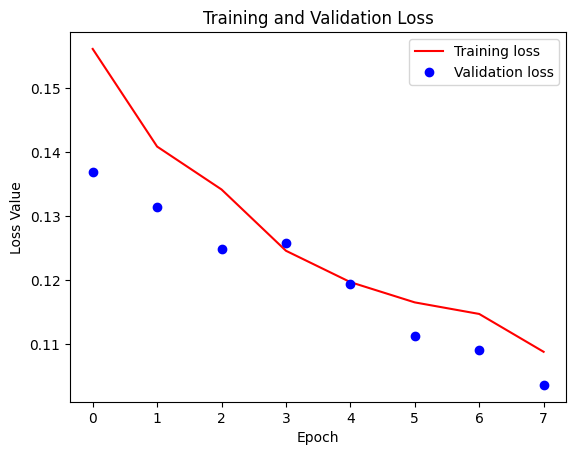

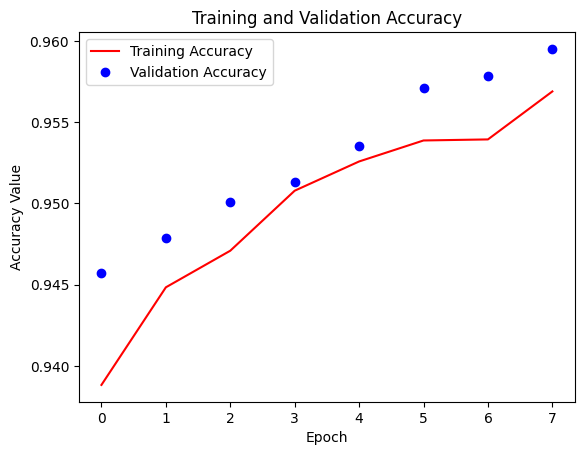

In [127]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim()
plt.legend()
plt.show()

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training Accuracy')
plt.plot(model_history.epoch, val_acc, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim()
plt.legend()
plt.show()

In [167]:
simple_model.save('./human_segmentation_256.keras')
#simple_model = tf.keras.models.load_model('./human_segmentation_128.keras')

In [ ]:
def show_predictions_bin(model, dataset, num=1):
  for image, mask in dataset.take(num):
    batch_size = 1
    for i in range(batch_size):
      pred_mask = model.predict(image)

      out = pred_mask[i] > 0.5
      
      display([image[i], mask[i], out])
      
  
show_predictions_bin(simple_model, train_dataset, num=10)

Save the original images with the mask applied to save computation later

In [131]:
def predict_and_save(model, image_path, save_path):
    # Preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Preprocess the image and mask
    image = tf.image.resize(image, (128, 128))
    image = image / 255
    # Make prediction
    print('test')
    display([image])
    mask = model.predict(image)
    print('test')
    binary_mask = np.where(mask > 0.5, 255, 0).astype(np.uint8)
    
    binary_mask = cv2.resize(binary_mask[0], (image.shape[2], image.shape[1]))
    # Load original image
    original_image = cv2.imread(image_path)
    # Convert mask to 3 channels
    masked_image = cv2.merge((binary_mask, binary_mask, binary_mask))
    # Apply mask to original image
    masked_image = cv2.bitwise_and(original_image, masked_image)
    # Save masked image
    cv2.imwrite(save_path, masked_image)
j = 1
for image, mask in train_dataset.take(600):
    batch_size = 1
    for i in range(batch_size):
        pred_mask = simple_model.predict(image)

        out = pred_mask[i] > 0.5
        out = out.astype(np.uint8)* 255
        filename = str(j)

        cv2.imwrite("./human_masks/" + filename.zfill(4)+".png", out)
        j += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━

Combine the generated masks with the original dataset by applying the mask

In [132]:
# Paths to folders containing masks and images
mask_folder = './human_masks'
image_folder = './images'
output_folder = './masked_images'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through all images in the mask folder
for filename in os.listdir(mask_folder):
    if filename.endswith('.png'):
        # Load mask
        mask_path = os.path.join(mask_folder, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Load corresponding image
        image_filename = filename.split('.')[0] + '.jpg'  # Assuming images are in jpg format
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (128, 128))
        # Apply mask to image
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        
        # Save masked image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, masked_image)

In [133]:
def create_unet_clothes(input_shape):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(7, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

Below is the code to train the model on a cleaned copy of the labels and images. This model was used for testing to determine if it was viable. This is NOT the final model.

In [149]:
# Seperate image processing for non boolean masks
def load_and_preprocess_image(image_path, mask_path):
    # Load the image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask)

    # Preprocess the image and mask
    image = tf.image.resize(image, (128, 128))
    mask = tf.image.resize(mask, (128, 128))

    image = image / 255
    
    return image, mask

In [135]:


clothes_label_data = tf.data.Dataset.list_files("./labels/*clothes.png", shuffle=False)
clothes_label_data_cleaned = tf.data.Dataset.list_files("./cleaned/*clothes.png", shuffle=False)

clothes_pairs = tf.data.Dataset.zip((train_data, clothes_label_data_cleaned))
clothes_dataset = clothes_pairs.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

clothes_train_size = int(0.8 * len(clothes_dataset))
clothes_train_dataset = clothes_dataset.take(clothes_train_size).batch(32)
clothes_validation_dataset = clothes_dataset.skip(clothes_train_size).batch(32)

# Create an instance of the UNet model
input_shape = (128, 128, 3) # adjust according to your input image size
clothes_simple_model = create_unet_clothes(input_shape)



Code used to determine how to clean the dataset. This will also be useful later on to add weighting to our dataset as background pixels are significantly over represented in the dataset.

In [136]:


# Initialize a dictionary to store counts of pixel values
pixel_counts = {}


# Iterate through all images in the dataset
for image, mask in clothes_dataset.take(50):
    # Convert image to NumPy array
    image_array = np.array(mask)
    # Flatten the image
    flattened_image = image_array.reshape((-1, 3))

    # Convert the flattened image to a tuple to use as a hashable key
    flattened_image_tuples = [tuple(pixel) for pixel in flattened_image]

    # Count occurrences of each pixel value
    unique_values, counts = np.unique(flattened_image_tuples, return_counts=True, axis=0)

    # Update pixel counts dictionary
    for value, count in zip(unique_values, counts):
        # Convert value from ndarray to tuple
        value_tuple = tuple(value)
        pixel_counts[value_tuple] = pixel_counts.get(value_tuple, 0) + count

# Sort pixel counts by count in descending order
sorted_pixel_counts = sorted(pixel_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 most common pixels and their counts
print("Top 20 Most Common Pixels:")
for pixel, count in sorted_pixel_counts[:20]:
    print(f"Pixel: {pixel}, Count: {count}")

for pixel, count in sorted_pixel_counts[:7]:
    print(f"{pixel}")

for pixel, count in sorted_pixel_counts[:7]:
    print(f"{count}")

Top 20 Most Common Pixels:
Pixel: (0.0, 0.0, 0.0), Count: 693212
Pixel: (128.0, 0.0, 0.0), Count: 26682
Pixel: (0.0, 128.0, 128.0), Count: 25008
Pixel: (128.0, 0.0, 128.0), Count: 21564
Pixel: (128.0, 128.0, 0.0), Count: 21243
Pixel: (0.0, 128.0, 0.0), Count: 13444
Pixel: (0.0, 0.0, 128.0), Count: 8713
Pixel: (120.0, 0.0, 0.0), Count: 171
Pixel: (24.0, 0.0, 0.0), Count: 158
Pixel: (8.0, 0.0, 0.0), Count: 141
Pixel: (88.0, 0.0, 0.0), Count: 133
Pixel: (56.0, 0.0, 0.0), Count: 129
Pixel: (72.0, 0.0, 0.0), Count: 124
Pixel: (104.0, 0.0, 0.0), Count: 123
Pixel: (88.0, 0.0, 88.0), Count: 112
Pixel: (72.0, 0.0, 72.0), Count: 93
Pixel: (0.0, 104.0, 104.0), Count: 88
Pixel: (40.0, 0.0, 0.0), Count: 86
Pixel: (40.0, 0.0, 40.0), Count: 83
Pixel: (104.0, 0.0, 104.0), Count: 82
(0.0, 0.0, 0.0)
(128.0, 0.0, 0.0)
(0.0, 128.0, 128.0)
(128.0, 0.0, 128.0)
(128.0, 128.0, 0.0)
(0.0, 128.0, 0.0)
(0.0, 0.0, 128.0)
693212
26682
25008
21564
21243
13444
8713


The masks have a slight gradient aronud colors, here we find the most common rgb values to create a "flatter" mask in terms of rgb so we can create a 128 by 128 by 7 (num classes) one hot "image" so we can take advantage of tensorflow's CategoricalCrossEntropy loss function

Now we iterate through the labels and remove all of the "gradient" pixels. This process was done and uploaded to google drive to save on computations

In [ ]:
valid_rgb_values = [
    [0.0, 0.0, 0.0],
    [128.0, 0.0, 0.0],
    [0.0, 128.0, 128.0],
    [128.0, 0.0, 128.0],
    [128.0, 128.0, 0.0],
    [0.0, 128.0, 0.0],
    [0.0, 0.0, 128.0],
]
# Function to process PNG files in a directory
def process_png_files(directory):
    # Iterate through PNG files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            # Read the PNG file
            print(filename)
            image = cv2.imread(os.path.join(directory, filename))

            # Iterate through each pixel in the image
            for y in range(image.shape[0]):
                for x in range(image.shape[1]):
                    # Check if the pixel's color is not in the list of valid RGB values
                    pixel_color = image[y, x].tolist()
                    if pixel_color not in valid_rgb_values:
                        # Set the pixel's color to black
                        image[y, x] = [0, 0, 0]

            # Save the modified image
            cv2.imwrite(os.path.join(directory, f"processed_{filename}"), image)


# Example usage: Process PNG files in the current directory
process_png_files(".")


We convert the color labels to one hots to be able to use TF's CategoricalCrossEntropy loss function here.

In [145]:
# Create a "color reference" tensor from image_colors
valid_rgb_values = [
    [0.0, 0.0, 0.0],
    [128.0, 0.0, 0.0],
    [0.0, 128.0, 128.0],
    [128.0, 0.0, 128.0],
    [128.0, 128.0, 0.0],
    [0.0, 128.0, 0.0],
    [0.0, 0.0, 128.0],
]
color_reference = tf.cast(tf.constant(valid_rgb_values), dtype=tf.float32)

# Load the image and obtain tensor with one-hot values
def create_one_hot(x, mask):
    valid_rgb_values = [
        [0.0, 0.0, 0.0],
        [128.0, 0.0, 0.0],
        [0.0, 128.0, 128.0],
        [128.0, 0.0, 128.0],
        [128.0, 128.0, 0.0],
        [0.0, 128.0, 0.0],
        [0.0, 0.0, 128.0],
    ]
    color_reference = tf.cast(tf.constant(valid_rgb_values), dtype=tf.float32)
    comp = tf.equal(mask[..., None, :], color_reference)
    one_hot = tf.cast(tf.reduce_all(comp, axis=-1), dtype=tf.float32)
    x = tf.cast(x, dtype=tf.float32)
    return x, one_hot

clothes_cleaned_dataset = clothes_dataset.map(create_one_hot, num_parallel_calls=tf.data.AUTOTUNE)

clothes_cleaned_train_size = int(0.8 * len(clothes_cleaned_dataset))
clothes_cleaned_train_dataset = clothes_cleaned_dataset.take(clothes_cleaned_train_size).batch(4)
clothes_cleaned_validation_dataset = clothes_cleaned_dataset.skip(clothes_cleaned_train_size).batch(4)

# Create an instance of the UNet model
input_shape = (128, 128, 3) # adjust according to your input image size
clothes_simple_model = create_unet_clothes(input_shape)



Below is the code to run the initial version of the cloth segmentation model, this model will not be used as the final model.

In [ ]:

adam_optimizer = tf.keras.optimizers.Adam()

clothes_simple_model.compile(optimizer=adam_optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
clothes_model_history = clothes_simple_model.fit(clothes_cleaned_train_dataset, epochs=10)
clothes_simple_model.save('./simple_clothes_segmentation.keras')


In [ ]:
clothes_loss = clothes_model_history.history['loss']

plt.figure()
plt.plot(clothes_model_history.epoch, clothes_loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

Some helper functions for displaying the result

In [ ]:
valid_rgb_values = [
    [0.0, 0.0, 0.0],
    [128.0, 0.0, 0.0],
    [0.0, 128.0, 128.0],
    [128.0, 0.0, 128.0],
    [128.0, 128.0, 0.0],
    [0.0, 128.0, 0.0],
    [0.0, 0.0, 128.0],
]

def one_hot_to_classes(one_hot_tensor, classes=valid_rgb_values):
    # Get the indices of the maximum value along the one-hot vector axis
    class_indices = tf.argmax(one_hot_tensor, axis=-1)
    # Map the class indices to the corresponding classes
    class_tensor = tf.gather(classes, class_indices)
    return class_tensor
  
def show_predictions_clothes(model, dataset, num=1):
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    for i in range(4):
      out = pred_mask[i]
      out = one_hot_to_classes(out)
      t = one_hot_to_classes(mask[i])
      display([image[i], t, out])


As most of the images are composed of backgrounds (see counts of pixel classes above), the model doesn't end up learning the clothing classification well but insteads just colors most things in as background unless it is absolutely certain that it is a piece of clothing. We can fix this by adjusting the class weights for the model. Initially, I tuned the class weights to be (number of occurences of class)/(total number of pixels), however, this ended up overestimating the most common clothing pieces. Below, we set our class weights based off the ratio of occurances except with the background weight being manually set to 1.0. Ranges from 0.8 to 1.5 appeared to provide good results, however we will overestimate clothing so when combined with the human segmentation and considering clothing, the model will have some more "opinions" to base its final estimations off of.

Train the model given the weights of the classes adjusting for background. Note that we dont use background weight 0.16 as it results in the entire image not containing a background as the model isnt penalized for guessing everything is clothing. 

In [139]:
counts = [693212, 26682, 25008, 21564, 21243, 13444, 8713]

# Calculate total number of samples
total = sum(counts)

# Calculate class weights to be inversely proportional to occurrences
class_weights = {i: total / (len(counts) * freq) for i, freq in enumerate(counts)}
print(class_weights)

{0: 0.16689720151575976, 1: 4.336074614239669, 2: 4.626325290192852, 3: 5.365198611442351, 4: 5.4462713767896656, 5: 8.605708335104348, 6: 13.278450918988048}


This also is not the final model, however it is a step in the right direction.

In [ ]:
input_shape = (128, 128, 3)
clothes_simple_model_weighted = create_unet_clothes(input_shape)
adam_optimizer = tf.keras.optimizers.Adam()

clothes_simple_model_weighted.compile(optimizer=adam_optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
clothes_model_weighted_history = clothes_simple_model_weighted.fit(clothes_cleaned_train_dataset, epochs=8, class_weight = {0: 1.2, 1: 4.336074614239669, 2: 4.626325290192852, 3: 5.365198611442351, 4: 5.4462713767896656, 5: 8.605708335104348, 6: 13.278450918988048})
#clothes_model_history = clothes_simple_model.fit(clothes_train_dataset, epochs=4)

clothes_weighted_loss = clothes_model_weighted_history.history['loss']

Epoch 1/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - accuracy: 0.7953 - loss: 3.1066
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 36s 302ms/step - accuracy: 0.8375 - loss: 2.7831
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 306ms/step - accuracy: 0.8133 - loss: 2.8297
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 309ms/step - accuracy: 0.8009 - loss: 2.6276
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 36s 303ms/step - accuracy: 0.7869 - loss: 2.4351
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 36s 303ms/step - accuracy: 0.8015 - loss: 2.1386
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 304ms/step - accuracy: 0.7937 - loss: 1.9762
Epoch 8/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 306ms/step - accuracy: 0.7859 - loss: 1.8104


In [ ]:
plt.figure()
plt.plot(clothes_model_weighted_history.epoch, clothes_weighted_loss, 'r', label='Training loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

This code was used to determine what the optimal weight of the background label should be. Below are some outdate old sample runs to see the effect of background label weight on prediction masks.

Epoch 1/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.7886 - loss: 3.2065
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.8229 - loss: 2.4068
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.7939 - loss: 2.0119
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 314ms/step - accuracy: 0.7916 - loss: 1.8140
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 325ms/step - accuracy: 0.8021 - loss: 1.5880
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 322ms/step - accuracy: 0.8075 - loss: 1.5274
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.8141 - loss: 1.4751
Epoch 8/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.8153 - loss: 1.4175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


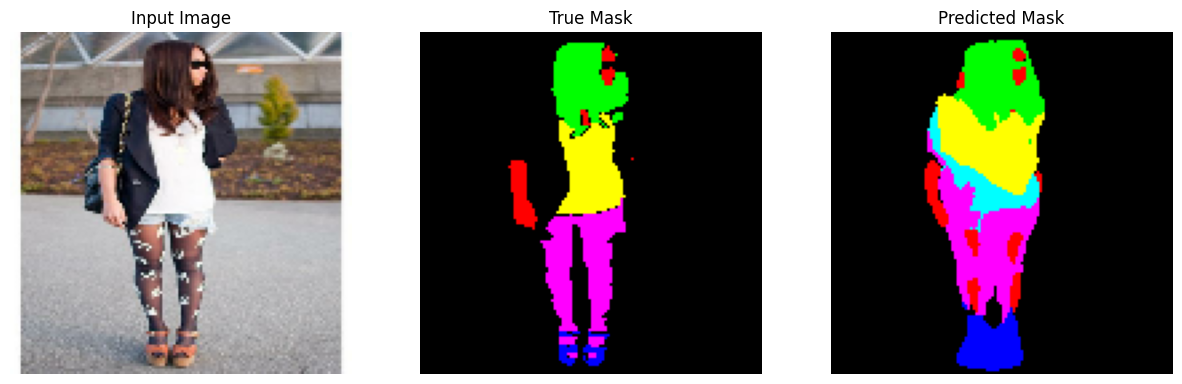

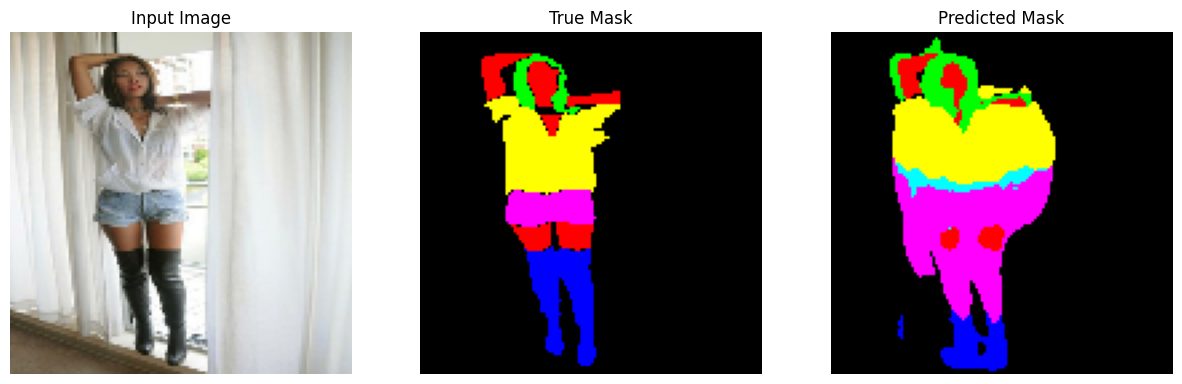

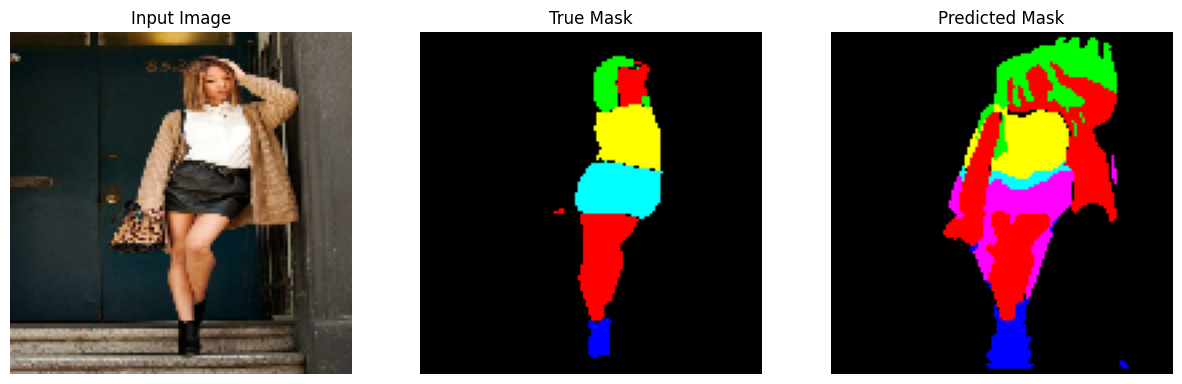

Epoch 1/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 306ms/step - accuracy: 0.8142 - loss: 3.6864
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 309ms/step - accuracy: 0.8307 - loss: 2.9254
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 306ms/step - accuracy: 0.8075 - loss: 2.5496
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 308ms/step - accuracy: 0.7956 - loss: 2.1852
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 306ms/step - accuracy: 0.7811 - loss: 1.8505
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 309ms/step - accuracy: 0.7939 - loss: 1.6991
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - accuracy: 0.7926 - loss: 1.6580
Epoch 8/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - accuracy: 0.7974 - loss: 1.6048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


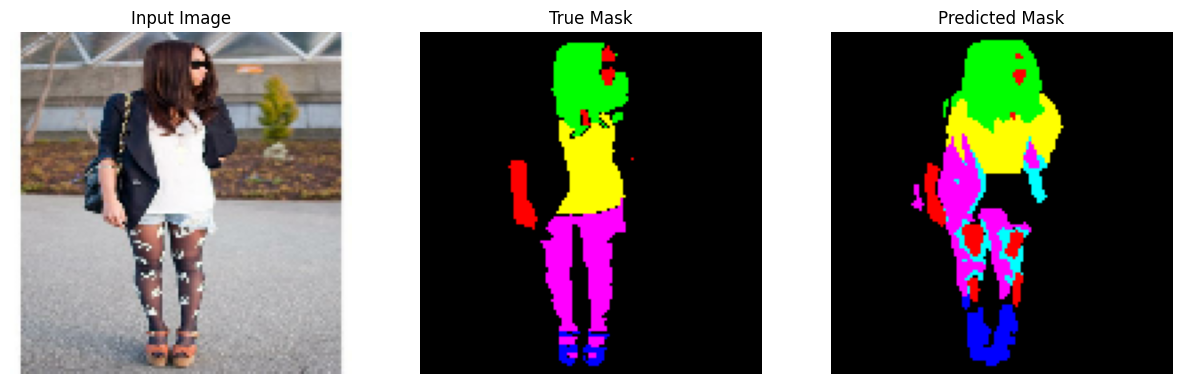

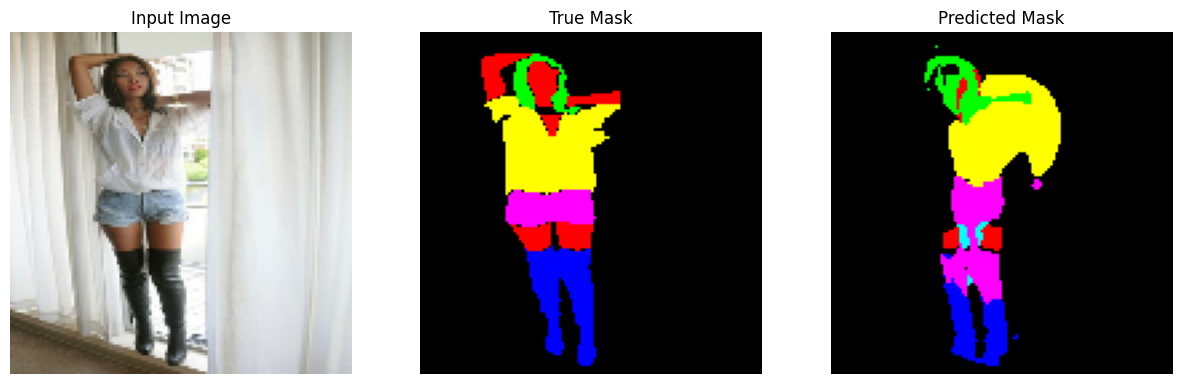

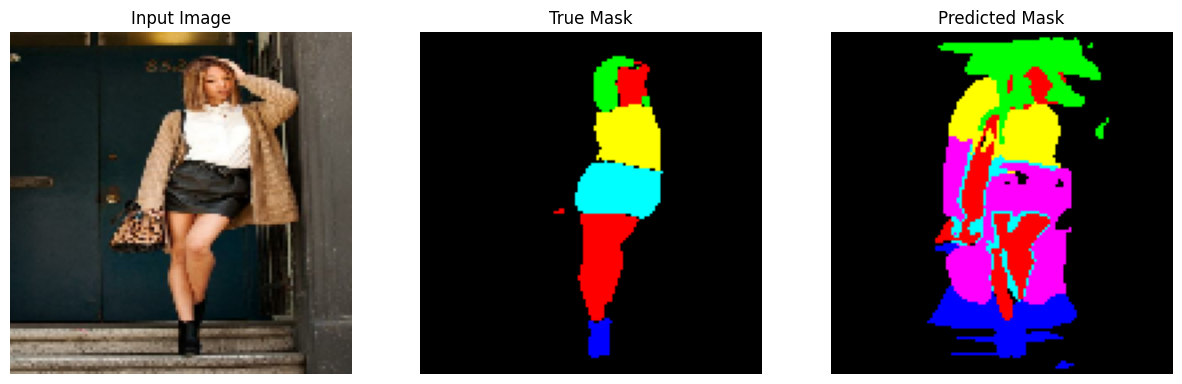

In [ ]:
background_weights = [(1 + i/20) for i in range(1, 10)]
background_weight_models = []
for w in background_weights:
    clothes_simple_model_weighted = create_unet_clothes(input_shape)
    background_weight_models.append(clothes_simple_model_weighted)
    adam = tf.keras.optimizers.Adam()
    clothes_simple_model_weighted.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    clothes_model_weighted_history = clothes_simple_model_weighted.fit(clothes_cleaned_train_dataset, epochs=8, class_weight = {0: w, 1: 4.336074614239669, 2: 4.626325290192852, 3: 5.365198611442351, 4: 5.4462713767896656, 5: 8.605708335104348, 6: 13.278450918988048})
    #clothes_model_history = clothes_simple_model.fit(clothes_train_dataset, epochs=4)

    clothes_weighted_loss = clothes_model_weighted_history.history['loss']
    show_predictions_clothes(clothes_simple_model_weighted, clothes_cleaned_train_dataset, num=1)



From the above data, we can see that combining human segmentation and a clothing segmentation by overlapping the output may be a feasable option in terms of prediction.

Below is some code to run canny edge detection on our dataset and save the outputs so that the outputs can later be used to possibly train the model. This was determined to be ineffective due to downscaling of our image resulting in the edges causing chaotic noise however the method is likely useful in scenarios where more computing power is available.

In [73]:
folder_path = './images'

# Create output folder if it doesn't exist
output_folder = './edges'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, "canny_edge_" + filename)  # Modify as needed

        # Read the image using OpenCV
        image = cv2.imread(input_path)
        
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Perform Canny edge detection
        edges = cv2.Canny(gray, 100, 200)  # Adjust thresholds as needed
        
        # Overlay the edges on the original image
        overlay = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        result = cv2.addWeighted(image, 1, overlay, 0.5, 0)  # Adjust parameters as needed
        
        # Save the result
        cv2.imwrite(output_path, result)

Below is the code to train the CNN model using the canny edge and pose estimation modified inputs. This model was deemed not a significant improvement on the base model. Although I suspect that canny edges would improve performance, I beleive it would only have a beneft if the image was kept at its original resolution as downscaling just makes it noise. Pose estimation proving to not be a benefit is due to the fact that the pose is directly overlaid ontop of the image instead of being computed and then fed into the CNN architecture. However, because that is too computationally expensive for both my laptop and Google Colab to train, it has been left out of all models EXCEPT for the base model where the pose estimation creating noise within the "human" label wouldn't matter.

In [ ]:

combine_label_data_cleaned = tf.data.Dataset.list_files("./cleaned/*clothes.png", shuffle=False)
combine_train_data = tf.data.Dataset.list_files("./poses_and_edges/*", shuffle=False)

combine_pairs = tf.data.Dataset.zip((combine_train_data, combine_label_data_cleaned))
combine_dataset = combine_pairs.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
combine_dataset = combine_dataset.map(create_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
combine_train_size = int(0.8 * len(combine_dataset))
combine_train_dataset = combine_dataset.take(combine_train_size).batch(8)
combine_validation_dataset = combine_dataset.skip(combine_train_size).batch(8)


input_shape = (128, 128, 3) 
clothes_simple_model_weighted_edge_pose = create_unet_clothes(input_shape)
adam = tf.keras.optimizers.Adam()


clothes_simple_model_weighted_edge_pose.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
clothes_model_weighted_pose_edge_history = clothes_simple_model_weighted_edge_pose.fit(combine_train_dataset, epochs=10, class_weight = {0: 1.31, 1: 4.336074614239669, 2: 4.626325290192852, 3: 5.365198611442351, 4: 5.4462713767896656, 5: 8.605708335104348, 6: 13.278450918988048})

clothes_weighted_loss = clothes_model_weighted_pose_edge_history.history['loss']

Code to overlay prediction masks ontop of original image

In [ ]:
def show_predictions_overlay(model, dataset, num=10):
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    for i in range(4):
      out = pred_mask[i]
      out = one_hot_to_classes(out) / 255
      t = one_hot_to_classes(mask[i]) / 255
      overlay = 0.6 * out + (1 - 0.4) * image[i]
      display([image[i], t, overlay])
      
show_predictions_overlay(clothes_simple_model_weighted_edge_pose, clothes_cleaned_train_dataset, num=10)


In [79]:
clothes_simple_model_weighted_edge_pose.save('./clothes_segmentation_edges_pose.keras')

The same model as above but without pose estimation overlay in training data

In [ ]:
edge_label_data_cleaned = tf.data.Dataset.list_files("./cleaned/*clothes.png", shuffle=False)
edge_train_data = tf.data.Dataset.list_files("./edges/*", shuffle=False)

edge_pairs = tf.data.Dataset.zip((edge_train_data, edge_label_data_cleaned))
edge_dataset = edge_pairs.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
edge_dataset = edge_dataset.map(create_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
edge_train_size = int(0.8 * len(edge_dataset))
edge_train_dataset = edge_dataset.take(edge_train_size).batch(8)
edge_validation_dataset = edge_dataset.skip(edge_train_size).batch(8)



input_shape = (128, 128, 3) 
clothes_simple_model_weighted_edge = create_unet_clothes(input_shape)
adam = tf.keras.optimizers.Adam()


clothes_simple_model_weighted_edge.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
clothes_model_weighted_history = clothes_simple_model_weighted_edge.fit(edge_train_dataset, epochs=11, class_weight = {0: 1.31, 1: 4.336074614239669, 2: 4.626325290192852, 3: 5.365198611442351, 4: 5.4462713767896656, 5: 8.605708335104348, 6: 13.278450918988048})
#clothes_model_history = clothes_simple_model.fit(clothes_train_dataset, epochs=4){0: 1, 1: 1.4, 2: 1.5, 3: 1.8, 4: 1.8, 5: 2.8, 6: 4}

clothes_weighted_loss = clothes_model_weighted_history.history['loss']
show_predictions_clothes(clothes_simple_model_weighted_edge, edge_train_dataset, num=10)

The same model as above but without canny edge overlay in training data

In [ ]:
poses_label_data_cleaned = tf.data.Dataset.list_files("./cleaned/*clothes.png", shuffle=False)
poses_train_data = tf.data.Dataset.list_files("./poses/*", shuffle=False)

poses_pairs = tf.data.Dataset.zip((poses_train_data, edge_label_data_cleaned))
poses_dataset = poses_pairs.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
poses_dataset = poses_dataset.map(create_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
poses_train_size = int(0.8 * len(poses_dataset))
poses_train_dataset = poses_dataset.take(poses_train_size).batch(8)
poses_validation_dataset = poses_dataset.skip(poses_train_size).batch(8)

input_shape = (128, 128, 3) 
clothes_simple_model_weighted_pose = create_unet_clothes(input_shape)
adam = tf.keras.optimizers.Adam()


clothes_simple_model_weighted_pose.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
clothes_simple_model_weighted_pose_history = clothes_simple_model_weighted_pose.fit(poses_train_dataset, epochs=11, class_weight = {0: 1.31, 1: 4.336074614239669, 2: 4.626325290192852, 3: 5.365198611442351, 4: 5.4462713767896656, 5: 8.605708335104348, 6: 13.278450918988048})

loss = clothes_simple_model_weighted_pose_history.history['loss']

In [ ]:
clothes_simple_model_weighted_pose.save('./clothes_segmentation_pose')
clothes_simple_model_weighted_edge.save('./clothes_segmentation_edge')

Below was the model that had the best performance. The model simply takes the human segmentation model, applies the mask that it generates, and trains clothing segmentation off of the dataset with that one modification.

In [152]:
mask_label_data_cleaned = tf.data.Dataset.list_files("./cleaned/*clothes.png", shuffle=False)
mask_train_data = tf.data.Dataset.list_files("./masked_images/*png", shuffle=False)

mask_pairs = tf.data.Dataset.zip((mask_train_data, mask_label_data_cleaned))
mask_dataset = mask_pairs.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
mask_dataset = mask_dataset.map(create_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
mask_train_size = int(0.8 * len(mask_dataset))
mask_train_dataset = mask_dataset.take(mask_train_size).batch(8)
mask_validation_dataset = mask_dataset.skip(mask_train_size).batch(8)

input_shape = (128, 128, 3) 
clothes_simple_model_weighted_mask = create_unet_clothes(input_shape)
adam = tf.keras.optimizers.Adam()


clothes_simple_model_weighted_mask.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
clothes_model_weighted_mask_history = clothes_simple_model_weighted_mask.fit(mask_train_dataset,validation_data=mask_validation_dataset, epochs=10, class_weight = {0: 1, 1: 4.336074614239669, 2: 4.626325290192852, 3: 5.365198611442351, 4: 5.4462713767896656, 5: 8.605708335104348, 6: 13.278450918988048})



Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 761ms/step - accuracy: 0.7468 - loss: 3.4045 - val_accuracy: 0.8033 - val_loss: 0.5586
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 813ms/step - accuracy: 0.8141 - loss: 2.0820 - val_accuracy: 0.7926 - val_loss: 0.5998
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 720ms/step - accuracy: 0.7997 - loss: 2.0189 - val_accuracy: 0.8056 - val_loss: 0.5381
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 810ms/step - accuracy: 0.8146 - loss: 1.9829 - val_accuracy: 0.8070 - val_loss: 0.5072
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 755ms/step - accuracy: 0.8048 - loss: 1.5700 - val_accuracy: 0.8199 - val_loss: 0.4556
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 737ms/step - accuracy: 0.8132 - loss: 1.4491 - val_accuracy: 0.8270 - val_loss: 0.4241
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 726ms/step - accuracy: 0.8165 - loss: 1.3482 - val_accuracy: 0.8333 - val_loss: 0.4110
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 766ms/step - accuracy: 0.8251 - loss: 1.3149 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


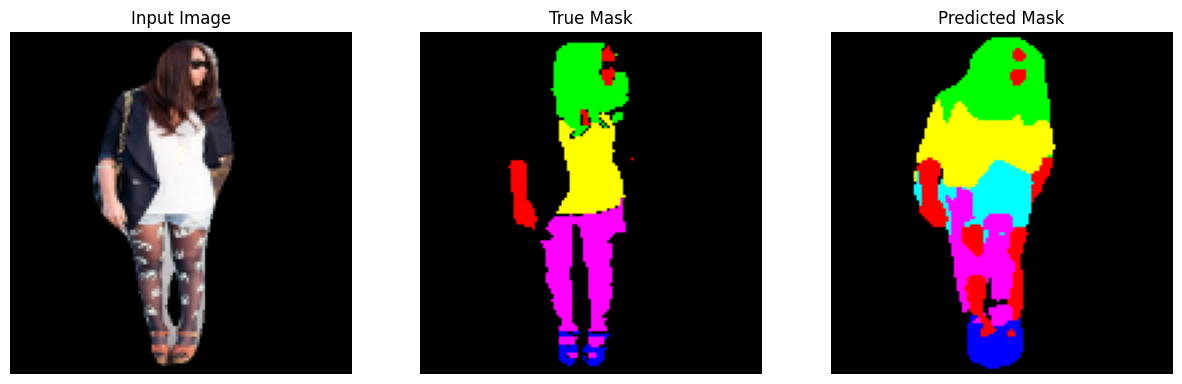

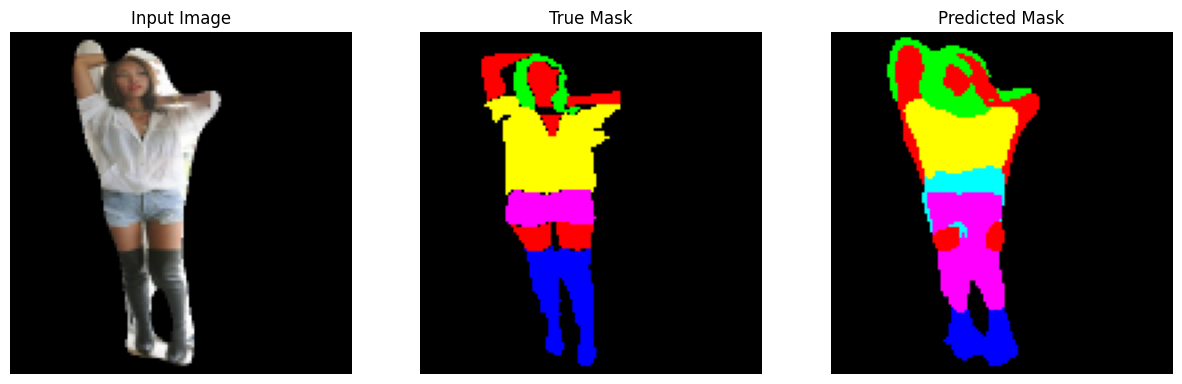

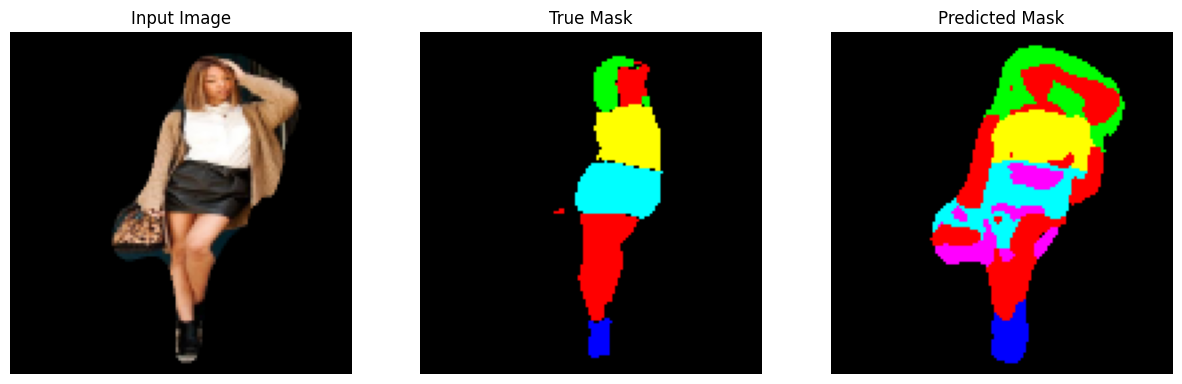

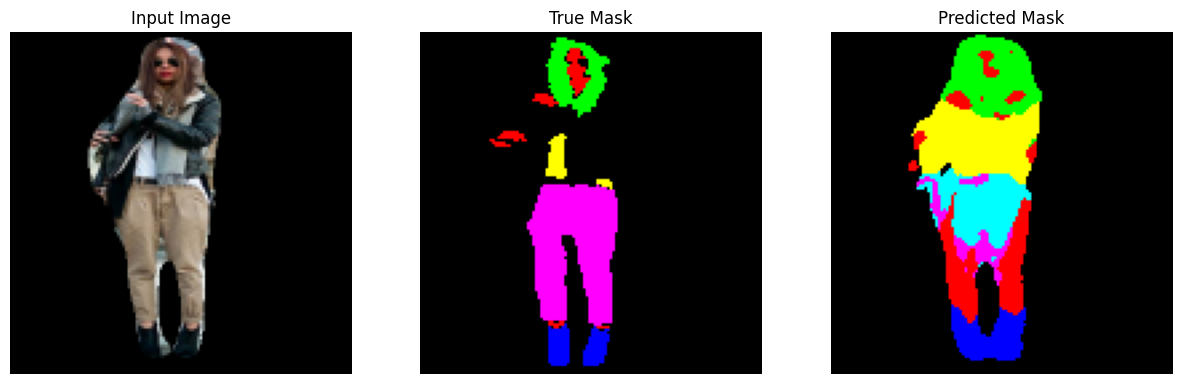

In [153]:
valid_rgb_values = [
    [0.0, 0.0, 0.0],
    [128.0, 0.0, 0.0],
    [0.0, 128.0, 128.0],
    [128.0, 0.0, 128.0],
    [128.0, 128.0, 0.0],
    [0.0, 128.0, 0.0],
    [0.0, 0.0, 128.0],
]

def one_hot_to_classes(one_hot_tensor, classes=valid_rgb_values):
    # Get the indices of the maximum value along the one-hot vector axis
    class_indices = tf.argmax(one_hot_tensor, axis=-1)
    # Map the class indices to the corresponding classes
    class_tensor = tf.gather(classes, class_indices)
    return class_tensor


show_predictions_clothes(clothes_simple_model_weighted_pose, mask_train_dataset, num=1)

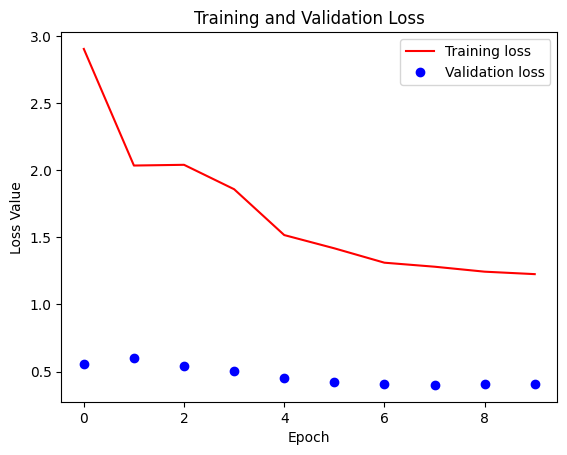

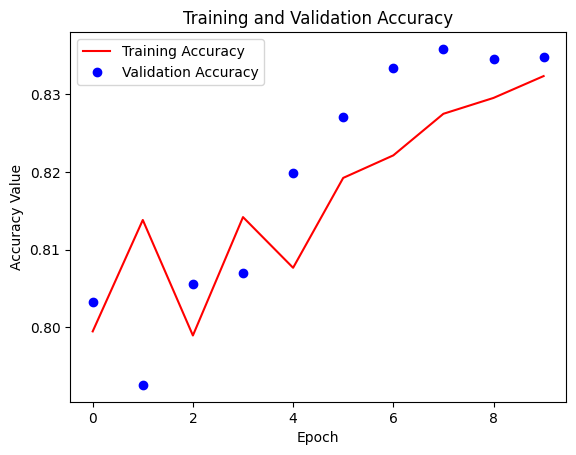

In [157]:
loss = clothes_model_weighted_mask_history.history['loss']
val_loss = clothes_model_weighted_mask_history.history['val_loss']

plt.figure()
plt.plot(clothes_model_weighted_mask_history.epoch, loss, 'r', label='Training loss')
plt.plot(clothes_model_weighted_mask_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim()
plt.legend()
plt.show()

acc = clothes_model_weighted_mask_history.history['accuracy']
val_acc = clothes_model_weighted_mask_history.history['val_accuracy']

plt.figure()
plt.plot(clothes_model_weighted_mask_history.epoch, acc, 'r', label='Training Accuracy')
plt.plot(clothes_model_weighted_mask_history.epoch, val_acc, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim()
plt.legend()
plt.show()